# Self-Implemented LDA Analysis

In [420]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler

from scipy.linalg import eigh as sp_eigh
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from mlxtend.plotting import plot_decision_regions

df = pd.read_csv('/home/aaronpham5504/personalFolder/MSA/Project/MSA-Vstatis/Data/Score.csv', encoding='ascii')
print(df.head(20))
print('Displayed first 20 rows of Score.csv')

    Delay_from_due_date  Num_of_Delayed_Payment  Num_Credit_Inquiries  \
0                   3.0                     7.0                   4.0   
1                   3.0                     7.0                   4.0   
2                   3.0                     7.0                   4.0   
3                   5.0                     4.0                   4.0   
4                   6.0                     4.0                   4.0   
5                   8.0                     4.0                   4.0   
6                   3.0                     8.0                   4.0   
7                   3.0                     6.0                   4.0   
8                   3.0                     4.0                   2.0   
9                   7.0                     1.0                   2.0   
10                  3.0                     1.0                   2.0   
11                  3.0                     3.0                   2.0   
12                  3.0                     1.0    

## Data Preprocessing

In [421]:
# 2. Kiểm tra và xử lý giá trị thiếu (nếu có)
df.dropna(inplace=True)  # Loại bỏ các dòng có giá trị NaN

# 3. Xác định biến mục tiêu và các cột cần encode
target_col = "Credit_Score"
categorical_cols = ["Credit_Mix", "Payment_Behaviour", "Payment_of_Min_Amount"]

# 4. Label Encoding cho biến mục tiêu và các cột phân loại
le_target = LabelEncoder()
df[target_col] = le_target.fit_transform(df[target_col])  # Encode Credit_Score

label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])  # Encode các cột phân loại khác
    label_encoders[col] = le

# 5. Tách biến đầu vào (X) và biến mục tiêu (y)
y_scaled = df[target_col]  # Nhãn phân loại
X = df.drop(columns=[target_col])  # Loại bỏ cột mục tiêu khỏi tập feature


# 6. Chuẩn hóa dữ liệu đầu vào
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # Áp dụng Standard Scaling

# 7. Chuyển X về DataFrame để dễ thao tác
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)
y_scaled_df = pd.DataFrame(y_scaled, columns=[target_col])

# 9. Split data thành train và test set
target_samples = 100

# Create the undersampler
undersampler = RandomUnderSampler(sampling_strategy={0: target_samples, 1: target_samples, 2: target_samples})

# Apply undersampling
X_resampled, y_resampled = undersampler.fit_resample(X_scaled, y_scaled)

# Check the new class distribution
print("Resampled dataset shape:", Counter(y_resampled))

class_counts = Counter(y_resampled)
print("Number of 0s:", class_counts[0])
print("Number of 1s:", class_counts[1])
print("Number of 2s:", class_counts[2])

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

X = np.array(X_resampled)
y = np.array(y_resampled)


Resampled dataset shape: Counter({0: 100, 1: 100, 2: 100})
Number of 0s: 100
Number of 1s: 100
Number of 2s: 100


## Within-class Variance

In [422]:
def calculate_within_class_scatter(X, y, num_classes):
    """
    Compute the within-class scatter matrix (Sw).

    Args:
        X (numpy.ndarray): Input data matrix (n_samples x n_features).
        y (numpy.ndarray): Class labels.
        num_classes (int): Number of classes.

    Returns:
        numpy.ndarray: Within-class scatter matrix (Sw).
    """
    n_features = X.shape[1]
    Sw = np.zeros((n_features, n_features))  # Initialize Sw

    for cls in range(num_classes):  # Iterate over each class
        X_cls = X[y == cls]  # Samples belonging to the current class
        if len(X_cls) > 0:
            mean_cls = np.mean(X_cls, axis=0)  # Mean vector of the class
            diff = X_cls - mean_cls  # Center the samples
            Sw += diff.T @ diff  # Accumulate scatter matrix

    return Sw

## Between Class Variance

In [423]:
def calculate_between_class_scatter(X, y, num_classes):
    """
    Compute the between-class scatter matrix (Sb).

    Args:
        X (numpy.ndarray): Input data matrix (n_samples x n_features).
        y (numpy.ndarray): Class labels.
        num_classes (int): Number of classes.

    Returns:
        numpy.ndarray: Between-class scatter matrix (Sb).
    """
    n_features = X.shape[1]
    overall_mean = np.mean(X, axis=0)  # Overall mean vector
    Sb = np.zeros((n_features, n_features))  # Initialize Sb

    for cls in range(num_classes):  # Iterate over each class
        X_cls = X[y == cls]  # Samples belonging to the current class
        n_cls = len(X_cls)  # Number of samples in the class
        if n_cls > 0:
            mean_cls = np.mean(X_cls, axis=0)  # Mean vector of the class
            diff = (mean_cls - overall_mean).reshape(-1, 1)  # (mean_cls - overall_mean)
            Sb += n_cls * (diff @ diff.T)  # Accumulate scatter matrix

    return Sb

## LDA Objective Function

In [424]:
def lda_objective_function(W, SW, SB):
    """
    Tính giá trị của hàm mục tiêu LDA cho ma trận chiếu W.

    Args:
        W (numpy.ndarray): Ma trận chiếu (d x m).
        SW (numpy.ndarray): Ma trận tán xạ nội tại (d x d).
        SB (numpy.ndarray): Ma trận tán xạ ngoại tại (d x d).

    Returns:
        float: Giá trị của hàm mục tiêu.
    """
    WT_SW_W = np.dot(W.T, np.dot(SW, W))
    WT_SB_W = np.dot(W.T, np.dot(SB, W))

    # Kiểm tra xem WT_SW_W có khả nghịch không
    try:
        WT_SW_W_inv = np.linalg.inv(WT_SW_W)
    except np.linalg.LinAlgError:
        print("Ma trận WT_SW_W là suy biến, không thể tính nghịch đảo.")
        return -np.inf  # Trả về giá trị âm vô cùng để biểu thị trường hợp không hợp lệ

    objective_value = np.trace(np.dot(WT_SW_W_inv, WT_SB_W))
    return objective_value

## Optimized Problem

In [425]:
def solve_lda(X, y, num_classes, num_components):
    """
    Solve the LDA optimization problem to find the projection matrix W.

    Args:
        X (numpy.ndarray): Input data matrix (n_samples x n_features).
        y (numpy.ndarray): Class labels.
        num_classes (int): Number of classes.
        num_components (int): Number of components to retain.

    Returns:
        numpy.ndarray: Projection matrix W (n_features x num_components).
    """
    # Compute scatter matrices
    Sw = calculate_within_class_scatter(X, y, num_classes)
    Sb = calculate_between_class_scatter(X, y, num_classes)

    # Solve the generalized eigenvalue problem for Sb and Sw
    try:
        eigenvalues, eigenvectors = eigh(Sb, Sw)  # Use scipy.linalg.eigh for stability
    except np.linalg.LinAlgError as e:
        print(f"Error solving eigenvalue problem: {e}")
        return None

    # Sort eigenvalues and eigenvectors in descending order
    sorted_indices = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[sorted_indices]
    eigenvectors = eigenvectors[:, sorted_indices]

    # Select the top num_components eigenvectors
    W = eigenvectors[:, :num_components]
    return W

## Classification

In [426]:
def predict_lda(X, W, X_train, y_train):
    """
    Predict class labels for new data points using LDA.

    Args:
        X (numpy.ndarray): Data to classify (n_samples x n_features).
        W (numpy.ndarray): Projection matrix (n_features x n_components).
        X_train (numpy.ndarray): Training data (n_samples x n_features).
        y_train (numpy.ndarray): Training labels (n_samples).

    Returns:
        numpy.ndarray: Predicted class labels (n_samples).
    """
    # Project the training data into the LDA space
    X_train_projected = X_train @ W

    # Compute class centroids in the LDA space
    classes = np.unique(y_train)
    centroids = np.array([X_train_projected[y_train == cls].mean(axis=0) for cls in classes])

    # Project the new data into the LDA space
    X_projected = X @ W

    # Assign each point to the nearest centroid
    distances = np.linalg.norm(X_projected[:, np.newaxis] - centroids, axis=2)
    predictions = classes[np.argmin(distances, axis=1)]

    return predictions

## Run On Customer Bank Dataset

In [427]:
sk_lda = LinearDiscriminantAnalysis(solver='eigen')
sk_lda.fit(X_train, y_train)
sk_lda_pred_res = sk_lda.predict(X_test)
sk_transformed = sk_lda.transform(X_train)
sk_lda_accuracy = accuracy_score(y_test, sk_lda_pred_res)

print(f'sk LDA accuracy: {sk_lda_accuracy}')
print(f'sk LDA prediction: {sk_lda_pred_res}')
print('sk transformed features', sk_transformed[:5].T, sep='\n')

sk LDA accuracy: 0.75
sk LDA prediction: [2 2 1 0 2 1 1 1 0 1 2 0 2 0 1 1 2 1 1 1 0 2 0 0 1 0 0 2 1 2 0 2 0 0 2 1 0
 0 0 0 0 0 1 0 0 0 1 1 1 1 1 0 2 0 1 2 0 0 1 2]
sk transformed features
[[-1.00352037  1.89034885  1.89877179 -1.99063954 -1.56027247]
 [ 1.0030799  -1.13891343  0.2479535   0.50975719 -1.18755261]]


In [428]:
# Assuming the original dataset is stored in a DataFrame called `df`
feature_names = df.columns  # Get the column names of the DataFrame

# Get the names of the features at indices 1 and 0
feature_at_index_1 = feature_names[1]
feature_at_index_0 = feature_names[0]

print(f"Feature at index 1: {feature_at_index_1}")
print(f"Feature at index 0: {feature_at_index_0}")

Feature at index 1: Num_of_Delayed_Payment
Feature at index 0: Delay_from_due_date


<Axes: title={'center': 'LDA surface with original features'}>

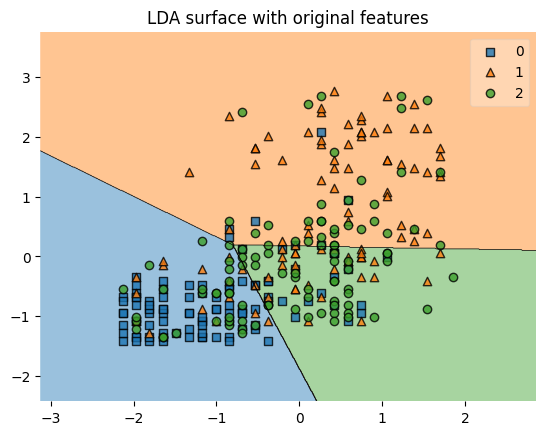

In [429]:
feature_indexes = [1, 0]
sk_lda1 = LinearDiscriminantAnalysis(solver='eigen')
sk_lda1.fit(X_train[:, feature_indexes], y_train)
plt.title('LDA surface with original features')
plot_decision_regions(X=X[:, feature_indexes], y=y, clf=sk_lda1)

(300, 2)


<Axes: title={'center': 'LDA surface with transformed features'}>

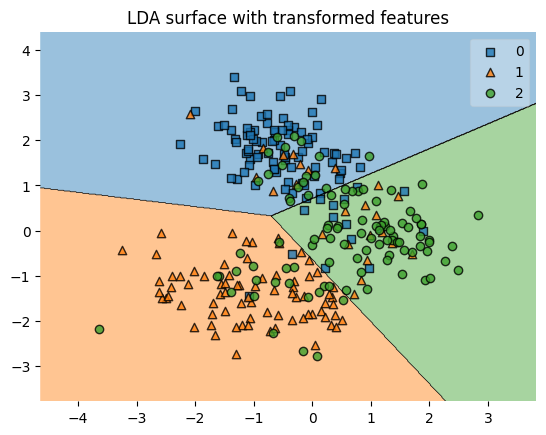

In [440]:
feature_indexes = [1, 0]
sk_lda2 = LinearDiscriminantAnalysis(solver='eigen')

X_lda = sk_lda2.fit(X, y).transform(X)

print(X_lda.shape)

X_lda = X_lda[:, feature_indexes]

X_lda_train, X_lda_test, y_train, y_test = train_test_split(X_lda, y, random_state=0)
sk_lda2.fit(X_lda_train, y_train)
plt.title('LDA surface with transformed features')
plot_decision_regions(X=X_lda, y=y, clf=sk_lda2)